# Phase Estimation Algorithm

This notebook demonstrates a simple implementation of the quantum phase estimation algorithm using Qiskit.

The phase estimation algorithm is used to estimate the eigenvalue phase θ of a unitary operator U, where U|ψ⟩ = e^(2πiθ)|ψ⟩.

## Overview
- **Input**: A unitary operator U and one of its eigenvectors |ψ⟩
- **Output**: An approximation of the phase θ such that U|ψ⟩ = e^(2πiθ)|ψ⟩
- **Method**: Uses controlled-U operations and the inverse quantum Fourier transform

Reference: [IBM Quantum Learning - Phase Estimation](https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/phase-estimation-procedure)

In [10]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt



## 1-Qubit Phase Estimation: The Simplest Case

We'll implement the simplest possible phase estimation using just **1 counting qubit** and an arbitrary eigenstate |ψ⟩.

This gives us a **single bit of accuracy** for the phase θ - essentially asking: "Is θ closer to 0 or closer to 1/2?"

The circuit follows the basic phase kickback principle from the IBM tutorial.

In [11]:
def single_qubit_phase_estimation(actual_theta_to_estimate: float) -> QuantumCircuit:
    """
    The simplest phase estimation: 1 counting qubit + 1 eigenstate qubit.
    
    This estimates whether phase θ is closer to 0 or 1/2.
    
    Args:
        actual_theta_to_estimate: The actual phase we want to estimate (for creating the eigenstate)
        
    Returns:
        QuantumCircuit: Simple 1-qubit phase estimation circuit
    """
    # 2 qubits total: 1 counting + 1 eigenstate
    circuit = QuantumCircuit(2, 1)
    
    # Prepare eigenstate |ψ⟩ such that U|ψ⟩ = e^(2πiθ)|ψ⟩
    # For simplicity, we'll use a phase gate P(2πθ) as our unitary U
    # and |0⟩ as the "eigenstate" (P|0⟩ = |0⟩, P|1⟩ = e^(2πiθ)|1⟩)
    # So we put target qubit in |1⟩ to get the phase
    circuit.x(1)  # Prepare |ψ⟩ = |1⟩
    
    # Step 1: Put counting qubit in superposition
    circuit.h(0)
    
    # Step 2: Apply controlled-U (controlled phase gate)
    circuit.cp(2 * np.pi * actual_theta_to_estimate, 0, 1)
    
    # Step 3: Apply Hadamard to counting qubit (this is the "inverse QFT" for 1 qubit)
    circuit.h(0)
    
    # Step 4: Measure the counting qubit
    circuit.measure(0, 0)
    
    return circuit

# Example 1: θ = 0.25
print("=== Example 1: θ = 0.25 ===")
circuit1 = single_qubit_phase_estimation(0.25)
print("Circuit:")
print(circuit1.draw())

# Run it
sampler = StatevectorSampler()
job1 = sampler.run([circuit1], shots=1024)
result = job1.result()[0]
counts1 = result.data.c.get_counts()
print(f"Results: {counts1}")

# Calculate probabilities
prob_0 = counts1.get('0', 0) / 1024
prob_1 = counts1.get('1', 0) / 1024
print(f"P(measure 0) = {prob_0:.3f}")
print(f"P(measure 1) = {prob_1:.3f}")
print(f"Theoretical: P(0) = cos²(π·{0.25}) = {np.cos(np.pi * 0.25)**2:.3f}")
print(f"Theoretical: P(1) = sin²(π·{0.25}) = {np.sin(np.pi * 0.25)**2:.3f}")

=== Example 1: θ = 0.25 ===
Circuit:
     ┌───┐         ┌───┐┌─┐
q_0: ┤ H ├─■───────┤ H ├┤M├
     ├───┤ │P(π/2) └───┘└╥┘
q_1: ┤ X ├─■─────────────╫─
     └───┘               ║ 
c: 1/════════════════════╩═
                         0 
Results: {'1': 496, '0': 528}
P(measure 0) = 0.516
P(measure 1) = 0.484
Theoretical: P(0) = cos²(π·0.25) = 0.500
Theoretical: P(1) = sin²(π·0.25) = 0.500


In [12]:
# Example 2: θ = 0.5 (should strongly favor measuring |1⟩)
print("\n=== Example 2: θ = 0.5 ===")
circuit2 = single_qubit_phase_estimation(0.5)
job2 = sampler.run([circuit2], shots=1024)
result2 = job2.result()[0]
counts2 = result2.data.c.get_counts()
print(f"Results: {counts2}")

prob_0 = counts2.get('0', 0) / 1024
prob_1 = counts2.get('1', 0) / 1024
print(f"P(measure 0) = {prob_0:.3f}")
print(f"P(measure 1) = {prob_1:.3f}")
print(f"Theoretical: P(0) = cos²(π·{0.5}) = {np.cos(np.pi * 0.5)**2:.3f}")
print(f"Theoretical: P(1) = sin²(π·{0.5}) = {np.sin(np.pi * 0.5)**2:.3f}")

# Example 3: θ = 0.0 (should strongly favor measuring |0⟩)  
print("\n=== Example 3: θ = 0.0 ===")
circuit3 = single_qubit_phase_estimation(0.0)
job3 = sampler.run([circuit3], shots=1024)
result3 = job3.result()[0]
counts3 = result3.data.c.get_counts()
print(f"Results: {counts3}")

prob_0 = counts3.get('0', 0) / 1024
prob_1 = counts3.get('1', 0) / 1024
print(f"P(measure 0) = {prob_0:.3f}")
print(f"P(measure 1) = {prob_1:.3f}")
print(f"Theoretical: P(0) = cos²(π·{0.0}) = {np.cos(np.pi * 0.0)**2:.3f}")
print(f"Theoretical: P(1) = sin²(π·{0.0}) = {np.sin(np.pi * 0.0)**2:.3f}")


=== Example 2: θ = 0.5 ===
Results: {'1': 1024}
P(measure 0) = 0.000
P(measure 1) = 1.000
Theoretical: P(0) = cos²(π·0.5) = 0.000
Theoretical: P(1) = sin²(π·0.5) = 1.000

=== Example 3: θ = 0.0 ===
Results: {'0': 1024}
P(measure 0) = 1.000
P(measure 1) = 0.000
Theoretical: P(0) = cos²(π·0.0) = 1.000
Theoretical: P(1) = sin²(π·0.0) = 0.000


## Understanding the 1-Qubit Results

The measurement probabilities follow the formula from the IBM tutorial:
- **P(measure 0) = cos²(πθ)**  
- **P(measure 1) = sin²(πθ)**

### Interpretation:
- **θ ≈ 0**: Measurement almost always gives |0⟩
- **θ ≈ 0.5**: Measurement almost always gives |1⟩  
- **θ ≈ 0.25 or 0.75**: Mixed results (50/50 probability)

This gives us **1 bit of accuracy** - we can distinguish between θ closer to 0 vs closer to 1/2.

=== Probability Distribution for Different θ Values ===
θ = 0.000 | P(0) = 1.000 (theory: 1.000) | P(1) = 0.000 (theory: 0.000)
θ = 0.125 | P(0) = 0.834 (theory: 0.854) | P(1) = 0.166 (theory: 0.146)
θ = 0.250 | P(0) = 0.509 (theory: 0.500) | P(1) = 0.491 (theory: 0.500)
θ = 0.375 | P(0) = 0.162 (theory: 0.146) | P(1) = 0.838 (theory: 0.854)
θ = 0.500 | P(0) = 0.000 (theory: 0.000) | P(1) = 1.000 (theory: 1.000)
θ = 0.625 | P(0) = 0.138 (theory: 0.146) | P(1) = 0.862 (theory: 0.854)
θ = 0.750 | P(0) = 0.496 (theory: 0.500) | P(1) = 0.504 (theory: 0.500)
θ = 0.875 | P(0) = 0.842 (theory: 0.854) | P(1) = 0.158 (theory: 0.146)


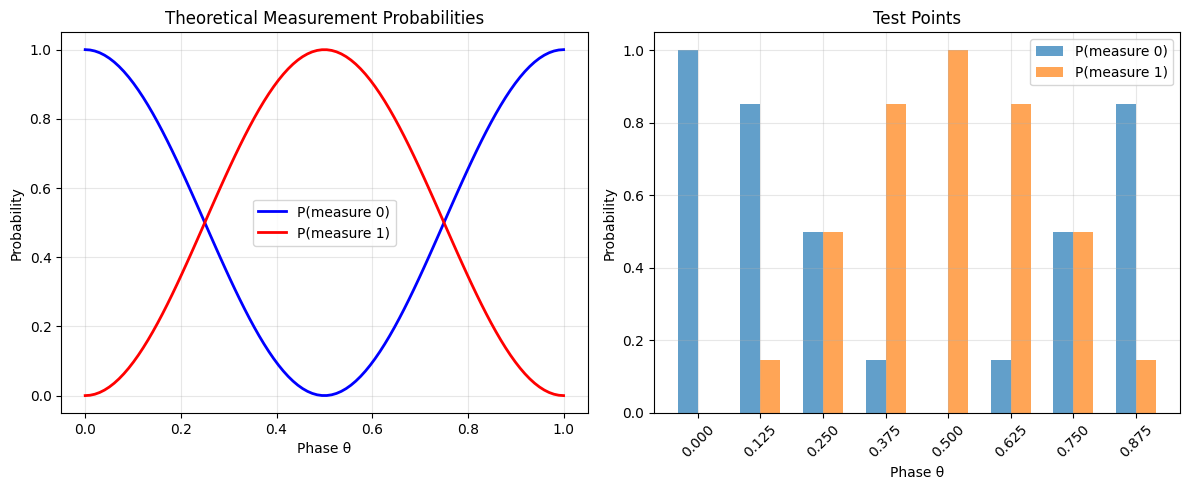

In [13]:
# Let's test a few more values to see the probability distribution
print("=== Probability Distribution for Different θ Values ===")
theta_values = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]

for theta in theta_values:
    circuit = single_qubit_phase_estimation(theta)
    job = sampler.run([circuit], shots=1024)
    counts = job.result()[0].data.c.get_counts()
    
    prob_0 = counts.get('0', 0) / 1024
    prob_1 = counts.get('1', 0) / 1024
    
    theoretical_0 = np.cos(np.pi * theta)**2
    theoretical_1 = np.sin(np.pi * theta)**2
    
    print(f"θ = {theta:.3f} | P(0) = {prob_0:.3f} (theory: {theoretical_0:.3f}) | P(1) = {prob_1:.3f} (theory: {theoretical_1:.3f})")

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Theoretical probabilities
theta_range = np.linspace(0, 1, 100)
prob_0_theory = np.cos(np.pi * theta_range)**2
prob_1_theory = np.sin(np.pi * theta_range)**2

plt.subplot(1, 2, 1)
plt.plot(theta_range, prob_0_theory, 'b-', label='P(measure 0)', linewidth=2)
plt.plot(theta_range, prob_1_theory, 'r-', label='P(measure 1)', linewidth=2)
plt.xlabel('Phase θ')
plt.ylabel('Probability')
plt.title('Theoretical Measurement Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Our test points
plt.subplot(1, 2, 2)
probs_0 = [np.cos(np.pi * theta)**2 for theta in theta_values]
probs_1 = [np.sin(np.pi * theta)**2 for theta in theta_values]

plt.bar([t - 0.02 for t in theta_values], probs_0, width=0.04, label='P(measure 0)', alpha=0.7)
plt.bar([t + 0.02 for t in theta_values], probs_1, width=0.04, label='P(measure 1)', alpha=0.7)
plt.xlabel('Phase θ')
plt.ylabel('Probability')
plt.title('Test Points')
plt.legend()
plt.xticks(theta_values, [f'{t:.3f}' for t in theta_values], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary: 1-Qubit Phase Estimation

This is the **simplest possible phase estimation** - using just 1 counting qubit to estimate 1 bit of phase information.

### Circuit Steps:
1. **Initialize**: Prepare eigenstate |ψ⟩ = |1⟩ 
2. **Superposition**: Apply H to counting qubit → |+⟩|1⟩
3. **Controlled-U**: Apply controlled phase gate → phase kickback occurs
4. **Interference**: Apply H to counting qubit → creates interference 
5. **Measure**: Get probabilistic result based on phase θ

### Key Insight:
The measurement probability **P(0) = cos²(πθ)** and **P(1) = sin²(πθ)** directly reveals information about θ with 1-bit precision.

This is the foundation for all quantum phase estimation algorithms!

# Extending to the general case
